# 1. 前準備 (csvの読み込みと紐づけ)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #seabornない人はpip installしてね
import os
from datetime import datetime
import numpy as np
from pathlib import Path

# カレントディレクトリを.pyと合わせるために以下を実行
if Path.cwd().name == "notebook":
    os.chdir("..")

# 設定
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_columns', 500)

# 浮動小数点数を小数点以下3桁で表示するように設定
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
# Mac Matplotlibのデフォルトフォントをヒラギノ角ゴシックに設定
plt.rcParams['font.family'] = 'Hiragino Sans'

In [4]:
# Windows MatplotlibのデフォルトフォントをMeiryoに設定
plt.rcParams['font.family'] = 'Meiryo'

In [5]:
# point_history.csvの読み込み
file_path_point_history = 'data/input/point_history_cleansing.csv'
df_point_history = pd.read_csv(file_path_point_history)

C:\Users\rocke\AppData\Local\Temp\ipykernel_4956\3923665265.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_point_history = pd.read_csv(file_path_point_history)


In [6]:
# user_info.csvの読み込み
file_path_user_info = 'data/input/user_info_cleansing.csv'
df_user_info = pd.read_csv(file_path_user_info)

In [7]:
# user_infoにageとage_groupのカラムを追加
# ageの算出・追加
df_user_info['birth_day'] = pd.to_datetime(df_user_info['birth_day'], errors='coerce')    # birth_dayをdatetimeに変換
current_year = pd.Timestamp.now().year
df_user_info['age'] = current_year - df_user_info['birth_day'].dt.year

# 年代の算出・追加
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_user_info['age_group'] = pd.cut(df_user_info['age'], bins=bins, labels=labels, right=False)

In [8]:
# point_history.csvとuser_info.csvをmerge (左内部結合)
df_merge = pd.merge(df_point_history, df_user_info, left_on='user_id', right_on='id', how='left')

In [9]:
# マージしたコードの確認
display(df_merge.head(100))
# display(df_merge.describe())
# #print(len(df_merge["user_uid"].unique()))
# #print(df_merge.info(verbose=True, show_counts=True))
# print(df_merge['nickname'].isna().sum())

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,total_amount,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group
0,0,22,2023,1.000,52.000,サン・マルシェ東中田店,superbig047780,1.000,2.000,2.000,2.000,98.000,1,NaN,0.000,0.000,2020-12-17 18:01:24,2020-12-17 18:01:24,2021-04-14 17:57:46,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,16307.000,2023.000,みみ,100.000,57.000,110.200,34.160,0.000,0.000,男,1978-09-29,9811107.000,45.000,41-50
1,1,27,90,1.000,52.000,サン・マルシェ東中田店,superbig011187,1.000,7.000,7.000,7.000,143.000,1,NaN,21.000,2.000,2020-12-18 10:59:56,2020-12-18 10:59:56,2020-12-31 13:57:54,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,88794.000,90.000,なおちんママ,2088.000,72.000,771.000,123.100,0.000,0.000,女,1967-08-30,9811107.000,56.000,51-60
2,2,34,670,1.000,52.000,サン・マルシェ東中田店,superbig035909,1.000,5.000,5.000,5.000,7.000,1,NaN,5.000,0.000,2020-12-18 14:30:36,2020-12-18 14:30:36,2020-12-31 13:58:58,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,64855.000,670.000,ゆみ,146.000,135.000,140.800,0.000,0.000,0.000,女,1968-02-12,9811103.000,55.000,51-60
3,3,38,725,1.000,52.000,サン・マルシェ東中田店,superbig016946,1.000,2.000,2.000,2.000,102.000,1,NaN,2.000,0.000,2020-12-18 18:31:55,2020-12-18 18:31:55,2020-12-31 13:59:25,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,70536.000,725.000,みい,1595.000,146.000,192.200,0.000,0.000,0.000,女,1988-06-28,9811103.000,35.000,31-40
4,4,39,205,1.000,52.000,サン・マルシェ東中田店,superbig000727,1.000,9.000,9.000,19.000,1567.000,1,NaN,9.000,0.000,2020-12-18 18:44:35,2020-12-18 18:44:35,2020-12-31 13:56:51,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,16580.000,205.000,Tomoo,831.000,139.000,553.500,111.100,0.000,0.000,女,1970-05-10,9811102.000,53.000,51-60
5,5,43,205,1.000,52.000,サン・マルシェ東中田店,superbig000727,1.000,7.000,7.000,7.000,1574.000,1,NaN,7.000,0.000,2020-12-19 11:20:13,2020-12-19 11:20:13,2020-12-31 13:56:43,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,16580.000,205.000,Tomoo,831.000,139.000,553.500,111.100,0.000,0.000,女,1970-05-10,9811102.000,53.000,51-60
6,6,60,539,1.000,52.000,サン・マルシェ東中田店,superbig053591,1.000,25.000,25.000,25.000,98.000,1,NaN,25.000,0.000,2020-12-19 16:49:40,2020-12-19 16:49:40,2020-12-31 14:01:51,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,51271.000,539.000,櫻井智子,2088.000,243.000,620.500,143.000,0.000,0.000,女,1970-11-04,9820003.000,53.000,51-60
7,7,61,162,1.000,52.000,サン・マルシェ東中田店,superbig013909,1.000,8.000,8.000,8.000,166.000,1,NaN,8.000,0.000,2020-12-19 16:53:02,2020-12-19 16:53:02,2020-12-31 14:01:29,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,12110.000,162.000,otchi1,36.000,122.000,594.500,210.200,71.000,3.000,女,1966-08-13,9811102.000,57.000,51-60
8,8,82,158,1.000,52.000,サン・マルシェ東中田店,superbig034486,1.000,14.000,14.000,14.000,150.000,1,NaN,42.000,2.000,2020-12-28 10:46:27,2020-12-28 10:46:27,2020-12-31 14:02:44,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,11693.000,158.000,ゆかりん,1035.000,184.000,1167.000,327.000,0.000,0.000,女,1974-01-17,9811101.000,49.000,41-50
9,9,94,230,1

# 2. 分析

## 2-1. rankごとの平均年間持込量kgの算出

・rank_id毎のrecycle_amount_per_year平均の算出  
・rankが高いほど、年間持ち込み量が多いという仮説を証明する(当然？)  
・rank_idは、0:ブロンズ、1:シルバー、2:ゴールド、3:プラチナ  
・1か月に15kg持ち込み続けるとランクUP。ランクダウンは不明(1か月15kgを達成しないとダウン説、、？)  
※以下の手順を踏むと「rank毎の1回の持ち込み量平均」になってしまうので注意  
　　① amount_kgは1回の持ち込み量。これをrank_id毎にsumする  
　　② rank_idそれぞれの出現回数をsumする  
　　③ ①を②で割る  

In [10]:
# まずそれぞれのカラムの基本統計量を確認しておく
print('recycle_amount_per_year')
print(df_merge['recycle_amount_per_year'].describe())
print('------------------')
print('rank_id')
print(df_merge['rank_id'].describe())
print('------------------')
print('rank_idのユニーク')
print(df_merge['rank_id'].unique())

recycle_amount_per_year
count   2124940.000
mean        239.305
std         617.446
min           0.000
25%          72.000
50%         139.000
75%         224.000
max       15460.000
Name: recycle_amount_per_year, dtype: float64
------------------
rank_id
count   2147086.000
mean          0.755
std           1.101
min           0.000
25%           0.000
50%           0.000
75%           1.000
max           3.000
Name: rank_id, dtype: float64
------------------
rank_idのユニーク
[ 0.  2.  1.  3. nan]


※rankは3（プラチナ）が不在な点に注意

In [11]:
# user_idの重複行を削除（非効率だと思いつつ、、、）
df_merge_duplicates_user_id = df_merge.drop_duplicates(subset='user_id')

ランク毎の持ち込みamountの平均 = df_merge.groupby('rank_id')['recycle_amount_per_year'].mean()
ランク毎の持ち込みamountの平均

rank_id
0.000   124.400
1.000   286.760
2.000   289.997
3.000   678.767
Name: recycle_amount_per_year, dtype: float64

### 得られた示唆

・ランクが高いほど、平均年間持ち込み量は多い  
　→「持ち込み量が多いから、ランクが上がった」という解釈の方が正しい？  
 ・rankのカラムのみ、user_infoに紐づけておくと、user_infoの情報量が増えてよいかも


## 2-2. ユーザ個人に着目して指針を得る 

### 2-2-1. トップユーザのamount_kg推移

・point、coin、rankが、ユーザの持ち込み量に影響を与えているのか確認  
・rankを維持したい人


In [12]:
# 'user_id'の各値の出現回数を計算
user_id_counts = df_merge['user_id'].value_counts().reset_index()
user_id_counts.columns = ['user_id', 'count']

# 元のDataFrameにcountをマージ
df_merge = df_merge.merge(user_id_counts, on='user_id')

# 出現回数に基づいてソート（降順）
df_merge = df_merge.sort_values(by='count', ascending=False)

In [14]:
# 重複を削除して、上位100名のcountをtableで俯瞰する
df_merged_duplicates_user_id = df_merge.drop_duplicates(subset='user_id')
top_100 = df_merged_duplicates_user_id.head(100)
top_100

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,total_amount,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group,count
727277,877594,12011006,27133,10.000,326.000,みやぎ生協大河原店,3150100225982,1.000,1.000,1.000,2.000,89.000,1,NaN,6.000,3.000,2023-05-04 11:38:27,2023-05-05 04:04:18,2023-05-05 04:04:18,339.000,みやぎ生協,大河原店,326,2022-04-23 03:15:28,2023-03-31 20:40:44,09:00:00,21:30:00,09:00:00,19:00:00,38.049,140.731,23464.000,27133.000,春,2282.000,129.000,2896.000,2060.000,0.000,0.000,女,1950-11-29,9891245.000,73.000,71-80,3127
34257,1558776,14657714,1152,3.000,11.000,ビフレ東通店,315bifre074937,1.000,0.000,0.000,1.000,142.000,1,NaN,0.000,3.000,2023-09-09 15:13:36,2023-09-10 04:00:19,2023-09-10 04:00:19,4.000,ビフレ,東通店,11,2021-09-21 04:02:39,2023-04-07 16:15:20,09:30:00,22:00:00,09:30:00,20:30:00,39.712,140.142,7122.000,1152.000,畠山寿子,21800.000,113.000,3410.000,807.500,0.000,0.000,女,1947-01-06,NaN,76.000,71-80,2071
1430569,1097110,13044986,38423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,3,NaN,0.000,0.000,2023-06-27 12:22:59,2023-06-27 12:22:59,2023-06-27 12:22:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,NaT,9800811.000,NaN,NaN,2027
38049,279391,7042287,912,3.000,168.000,ビフレ新庄店,315bifre056848,1.000,0.000,0.000,1.000,92.000,1,NaN,0.000,0.000,2022-08-10 19:53:47,2022-08-11 04:00:21,2022-08-11 04:00:21,7.000,ビフレ,新庄店,168,2021-09-21 04:12:05,2023-04-07 16:24:30,09:00:00,20:50:00,09:00:00,20:00:00,38.760,140.289,90117.000,912.000,ハルヤマサンポ,317.000,21.000,305.200,100.750,0.000,1.000,男,1948-03-30,9960027.000,75.000,71-80,2003
1061304,1922680,15828773,37378,9.000,NaN,NaN,7600001477764093,NaN,NaN,NaN,NaN,NaN,4,NaN,-500.000,3.000,2023-11-01 09:02:23,2023-11-01 09:02:23,2023-11-01 09:02:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34111.000,37378.000,Gue,11350.000,0.000,10040.000,7252.000,0.000,0.000,女,NaT,9810964.000,NaN,NaN,1764
881438,1136109,13196472,24467,9.000,1194.000,NaN,7600005574265474,1.000,6.000,6.000,0.000,0.000,1,NaN,36.000,3.000,2023-07-03 11:48:25,2023-07-05 00:07:11,2023-07-05 00:07:11,399.000,ヨークベニマル,鹿沼千渡店,ITOYOKADO0001194,2022-06-24 13:53:29,2023-03-31 20:40:44,09:30:00,21:30:00,09:30:00,20:00:00,36.567,139.778,20695.000,24467.000,ことにーにー,2230.000,0.000,11420.000,9170.000,0.000,0.000,男,1970-07-24,3220025.000,53.000,51-60,1670
391143,1361350,13986736,8130,9.000,132.000,NaN,7600090538362922,1.000,6.000,6.000,0.000,0.000,1,NaN,36.000,3.000,2023-08-08 20:15:04,2023-08-10 00:21:51,2023-08-10 00:21:51,138.000,ヨークベニマル,泉が丘店,ITOYOKADO0000132,2021-09-22 00:59:13,2023-04-08 15:08:35,09:30:00,21:45:00,09:30:00,21:00:00,36.568,139.919,79632.000,8130.000,ポイントゲッター,33180.000,0.000,7144.000,6916.000,0.000,0.000,男,NaT,3210951.000,NaN,NaN,1196
44256,117691,3415216,1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,3,NaN,5000.000,3.000,2022-02-01 11:33:43,2022-02-01 11:33:43,2022-02-01 11:33:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6366.000,1083.000,オバラ,361.000,80.000,2920.000,898.000,0.000,0.000,女,1963-06-26,NaN,60.000,61-70,1173
31522,48836,1438443,1593,3.000,11.000,ビフレ東通店,315bifre016209,1.000,0.000,0.000,1.000,149.000,1,NaN,0.000,0.000,2021-06-22 10:02:11,2021-06-23 02:00:52,2021-06-23 02:00:52,4.000,ビフレ,東通店,11,2021-09-21 04:02:39,2023-04-07 16:15:20,09:30:00,22:00:00,09:30:00,20:30:00,39.712,140.142,11832.000,1593.000,sakura,2208.000,98.000,543.000,185.500,0.000,0.000,女,1977-12-17,NaN,46.000,41-50,1172
910457,616755,10310482,27451,9.000,NaN,NaN,7600000824961709,NaN,NaN,NaN,NaN,NaN,4,NaN,-500.000,3.000,2023-02-07 00:00:44,2023-02-07 00:00:44,2023-02-07 00:00:44,NaN,NaN,NaN,Na

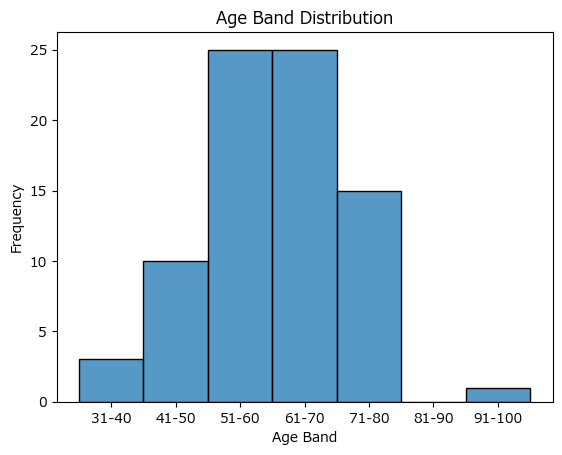

In [15]:
# top_100の年代別人数を表示
sns.histplot(data=top_100, x='age_group')

plt.title('Age Band Distribution')
plt.xlabel('Age Band')
plt.ylabel('Frequency')

plt.show()

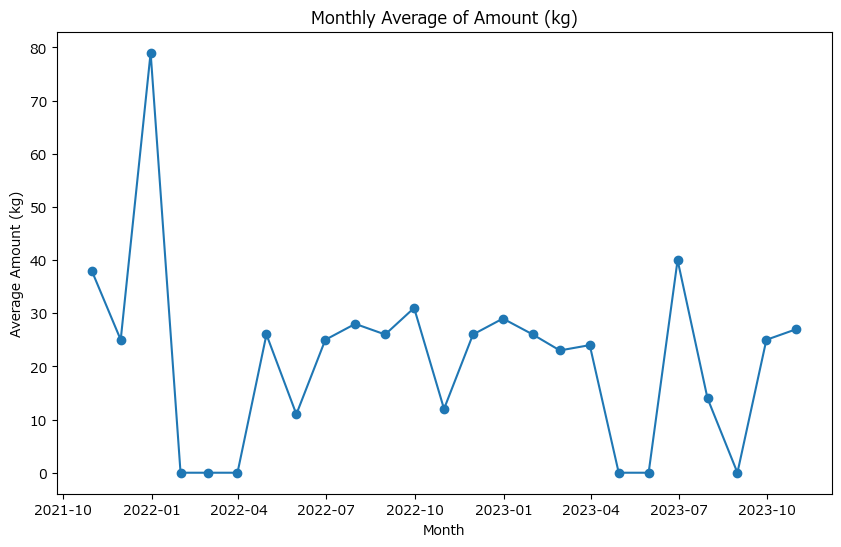

In [16]:
# 1位の人のamount_kgの推移を確認
# 1位の人のデータのみ抽出
df_merge_first = df_merge[df_merge['user_id'] == 3127]
df_merge_first = df_merge_first.sort_values(by='use_date', ascending=True)

df_merge_first['use_date'] = pd.to_datetime(df_merge_first['use_date'])

# use_dateを月ごとに集約（データ数が多すぎて折れ線グラフが見づらい）
df_merge_first_monthly = df_merge_first[['use_date', 'amount_kg']].resample('M', on='use_date').sum()

# 集約されたデータで折れ線グラフを作成
plt.figure(figsize=(10, 6))
plt.plot(df_merge_first_monthly.index, df_merge_first_monthly['amount_kg'], marker='o')

plt.title('Monthly Average of Amount (kg)')
plt.xlabel('Month')
plt.ylabel('Average Amount (kg)')
plt.show()